In [1]:
!pip install "numpy==1.23.5" --user

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 35.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorboard 2.10.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
rmm 22.10.0a0+38.ge043158.dirty requires cuda-python<11.7.1,>=11.5, but you have cuda-python 11.8.2 which is incompatible.
cudf 22.10.0a0+316.gad1ba132d2.dirty requires cuda-python<11.7.1,>=11.5, but you have cuda-python 11.8.2 which is incompatible.


GPU Detected: NVIDIA A100-SXM4-40GB

Starting CuPy RawKernel Benchmark (A100)...
Grid Size       | Time (s)        | MNodes/s       
------------------------------------------------------------
1000x1000        | 0.00100         | 100126.62      
2000x2000        | 0.00456         | 87779.08       
4000x4000        | 0.01742         | 91838.11       
8000x8000        | 0.06879         | 93033.61       


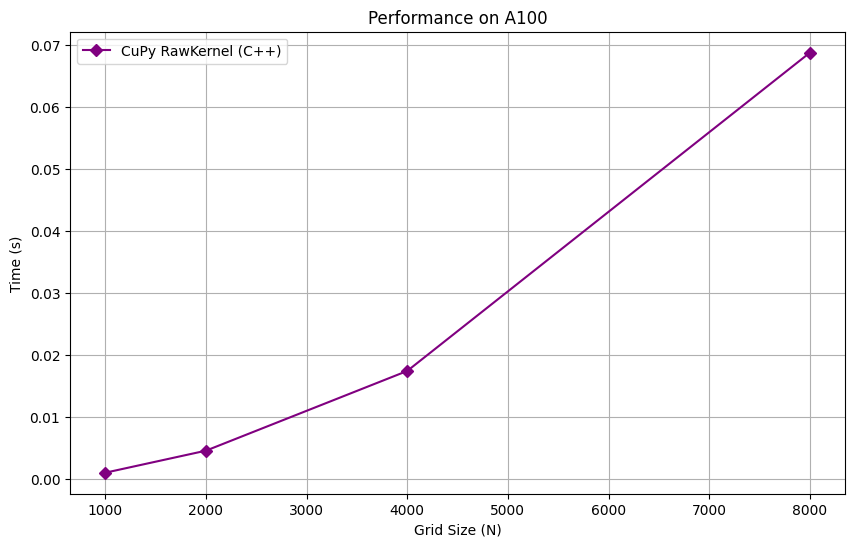

In [2]:
import sys
import os
import site

user_site = site.getusersitepackages()
if user_site not in sys.path:
    sys.path.insert(0, user_site)

import cupy as cp
import numpy as np
import time
import math
import matplotlib.pyplot as plt

# ==========================================
# 1. CUDA C++ Kernel
# ==========================================
cuda_source = r'''
extern "C" __global__
void poisson_shared_kernel(const float* u_in, float* u_out, const float* b, int N, int M) {
    // Static Shared Memory: 16x16 block + 2 halo = 18x18
    __shared__ float s_u[18][18];

    int tx = threadIdx.x;
    int ty = threadIdx.y;
    
    // Global coordinates
    int x = blockIdx.x * blockDim.x + tx;
    int y = blockIdx.y * blockDim.y + ty;
    
    // Linear index for global memory
    int idx = y * M + x;
    
    // Shared memory coordinates (with halo offset)
    int sx = tx + 1;
    int sy = ty + 1;

    // --- 1. Load Data into Shared Memory ---
    s_u[sy][sx] = 0.0f;
    if (y < N && x < M) {
        s_u[sy][sx] = u_in[idx];
    }

    // --- 2. Halo Loading ---
    // Top
    if (ty == 0 && y > 0) s_u[0][sx] = u_in[(y - 1) * M + x];
    // Bottom
    if (ty == 15 && y < N - 1) s_u[17][sx] = u_in[(y + 1) * M + x];
    // Left
    if (tx == 0 && x > 0) s_u[sy][0] = u_in[y * M + (x - 1)];
    // Right
    if (tx == 15 && x < M - 1) s_u[sy][17] = u_in[y * M + (x + 1)];

    __syncthreads();

    // --- 3. Computation ---
    if (y > 0 && y < N - 1 && x > 0 && x < M - 1) {
        float val = s_u[sy - 1][sx] + s_u[sy + 1][sx] + s_u[sy][sx - 1] + s_u[sy][sx + 1];
        u_out[idx] = 0.25f * (val - b[idx]);
    }
}
'''

# Compile the kernel
poisson_kernel = cp.RawKernel(cuda_source, 'poisson_shared_kernel')

# ==========================================
# 2. Benchmark Logic
# ==========================================
def run_benchmark():
    try:
        device_name = cp.cuda.runtime.getDeviceProperties(0)['name'].decode()
        print(f"GPU Detected: {device_name}")
    except:
        print("Error: CuPy cannot connect to GPU.")
        return

    print("\nStarting CuPy RawKernel Benchmark (A100)...")
    
    grid_sizes = [1000, 2000, 4000, 8000]
    iters = 100
    TPB = 16
    times = []
    
    print(f"{'Grid Size':<15} | {'Time (s)':<15} | {'MNodes/s':<15}")
    print("-" * 60)

    for n in grid_sizes:
        try:
            # Prepare data on GPU directly
            u = cp.zeros((n, n), dtype=cp.float32)
            b = cp.random.rand(n, n, dtype=cp.float32)
            u_out = cp.zeros_like(u)
            
            # Grid Configuration
            block_dim = (TPB, TPB)
            grid_x = int(math.ceil(n / TPB))
            grid_y = int(math.ceil(n / TPB))
            grid_dim = (grid_x, grid_y)
            
            # Warmup
            poisson_kernel(grid_dim, block_dim, (u, u_out, b, n, n))
            cp.cuda.Stream.null.synchronize()
            
            # Timing
            t0 = time.time()
            for i in range(iters):
                if i % 2 == 0:
                    poisson_kernel(grid_dim, block_dim, (u, u_out, b, n, n))
                else:
                    poisson_kernel(grid_dim, block_dim, (u_out, u, b, n, n))
            
            cp.cuda.Stream.null.synchronize()
            t1 = time.time()
            
            total_time = t1 - t0
            mnodes = (n * n * iters) / total_time / 1e6
            print(f"{n}x{n:<11} | {total_time:<15.5f} | {mnodes:<15.2f}")
            times.append(total_time)
            
            # Clean up
            del u, b, u_out
            cp.get_default_memory_pool().free_all_blocks()
            
        except Exception as e:
            print(f"{n}x{n} Error: {e}")
            times.append(0)

    # Plot
    if sum(times) > 0:
        plt.figure(figsize=(10, 6))
        plt.plot(grid_sizes, times, 'D-', color='purple', label='CuPy RawKernel (C++)')
        plt.xlabel('Grid Size (N)')
        plt.ylabel('Time (s)')
        plt.title('Performance on A100')
        plt.grid(True)
        plt.legend()
        plt.show()

if __name__ == "__main__":
    run_benchmark()